In [1]:
## caged_brach
%reload_ext autoreload
%autoreload 2

import pandas as pd
import geopandas as gpd
import numpy as np

pd.options.display.max_columns = 999
pd.options.display.max_rows = 1999
pd.options.display.max_colwidth = 200

import basedosdados as bd
from geobr import read_municipality, read_state

import plotly.express as px

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as image
import matplotlib.ticker as mtick
from matplotlib.colors import ListedColormap
from matplotlib.offsetbox import  OffsetImage
from matplotlib import colors, cm

from mpl_toolkits.axes_grid1 import make_axes_locatable

### Refs

- [google](https://www.google.com.br/search?q=high+school+race+us+map&hl=pt-BR&sxsrf=ALeKk025ryNlkzzMnPWJaybuQMK7sjpvmQ:1620515506596&tbm=isch&source=iu&ictx=1&fir=bA3OQhLFXqPvKM%252CYxgSnNL9hfIniM%252C_&vet=1&usg=AI4_-kQn3AIYsBQCaND7fpfFC7ScH1kFqA&sa=X&ved=2ahUKEwifhv7YmrvwAhU1pZUCHfSBAU4Q9QF6BAgOEAE#imgrc=YirASAz_MsudVM)

- [Vox - 3 maps that show school segregation in the US](https://www.vox.com/xpress/2014/8/28/6078583/3-maps-that-show-how-segregated-americas-schools-are)

- [America is more diverse than ever — but still segregated ](https://www.washingtonpost.com/graphics/2018/national/segregation-us-cities/)


- [Nexo - Onde estão os estudantes de ensino superior no Brasil](https://www.nexojornal.com.br/grafico/2019/05/14/Onde-est%C3%A3o-os-estudantes-de-ensino-superior-no-Brasil)

In [8]:
# query = """
# WITH censo_escola as (
# SELECT *
# FROM `basedosdados-dev.br_inep_censo_escolar.matricula`
# )
# SELECT 
#   ano,
#   sigla_uf,
#   id_municipio,
#   rede,
#   CASE 
#       WHEN sexo = 1 THEN "Masculino"
#       WHEN sexo = 2 THEN "Feminino"
#       WHEN sexo = -1 THEN "Ignorado"
#       WHEN sexo IS NULL THEN "Nao consta"
#   END AS sexo,
#   CASE 
#       WHEN raca_cor = 0 THEN "Nao declarado"
#       WHEN raca_cor = 1 THEN "Branca"
#       WHEN raca_cor = 2 THEN "Preta"
#       WHEN raca_cor = 3 THEN "Parda"
#       WHEN raca_cor = 4 THEN "Amarela"
#       WHEN raca_cor = 5 THEN "Indigena"
#       WHEN raca_cor IS NULL THEN "Nao consta"
#   END as raca_cor,
#   SUM(1) as matriculas
# FROM censo_escola
# GROUP BY 1,2,3,4,5,6
# """

# df = bd.read_sql(query, billing_project_id='basedosdados-dev')
# df.to_parquet('../data/censo_escolar/matriculas_raca_cor.parquet')

In [2]:
matriculas = pd.read_parquet('../data/censo_escolar/matriculas_raca_cor.parquet')

In [21]:
palete = {
    'amarelo':"#F5E663",
    'azul':"#3690C0",
    'verde':"#3F784C",
    'vermelho':"#e64e4e",
    'roxo':"#9970AB",
    'preto':'#262626'
}


palete = {
    'amarelo':"#D9CA4A",
    'azul':"#4A8AD9",
    'verde':"#4AD96B",
    'vermelho':"#D95A4A",
    'roxo':"#724AD9",
    'preto':'#262626'
}

In [93]:
### Area Plot
matriculas_rede = (
    matriculas[["ano", "rede", "raca_cor", "matriculas"]]
    .groupby(by=["ano", "rede", "raca_cor"])
    .sum()
)
matriculas_rede = (
    matriculas_rede.groupby(level=["ano", "rede"])
    .apply(lambda x: 100 * x / float(x.sum()))
    .reset_index()
)
matriculas_rede["rede"] = np.where(
    matriculas_rede["rede"] == "privada", "privada", "publica"
)

In [94]:
matriculas_2020 = matriculas[matriculas["ano"] == 2020]
matriculas_2020["rede"] = np.where(
    matriculas_2020["rede"] == "privada", "privada", "publica"
)

matriculas_2020 = (
    matriculas_2020
    .groupby(by=["id_municipio", "rede", "raca_cor"])
    .sum()
    .drop("ano", 1)
)
matriculas_municipio = (
    matriculas_2020.groupby(level=["id_municipio", "rede"])
    .apply(lambda x: 100 * x / float(x.sum()))
    .reset_index()
)

mask_publico = (matriculas_municipio["rede"] == "publica")  ## & (matriculas_municipio["raca_cor"] != "Nao declarado")

publico = (
    matriculas_municipio[mask_publico]
    .sort_values(by=["id_municipio", "matriculas"], ascending=False)
    .drop_duplicates(subset="id_municipio", keep="first")
)

mask_privado = (matriculas_municipio["rede"] == "privada") ## & (matriculas_municipio["raca_cor"] != "Nao declarado")

privado = (
    matriculas_municipio[mask_privado]
    .sort_values(by=["id_municipio", "matriculas"], ascending=False)
    .drop_duplicates(subset="id_municipio", keep="first")
)


mun = read_municipality(code_muni="all", year=2019)
states = read_state(code_state="all", year=2019)

df_publico = pd.merge(publico,mun, left_on='id_municipio', right_on='code_muni', how='outer')
df_publico = gpd.GeoDataFrame(df_publico)

cols = ['id_municipio','name_muni','rede','raca_cor','matriculas','geometry']
df_publico = df_publico[cols]

df_privado = pd.merge(privado,mun, left_on='id_municipio', right_on='code_muni', how='outer')
df_privado = gpd.GeoDataFrame(df_privado)

df_privado = df_publico[cols]


### Area Plot

In [95]:
def plot_rede(matriculas_rede, selected_rede):
    rede = matriculas_rede[matriculas_rede["rede"] == selected_rede]
    rede = rede.pivot_table(
        columns="raca_cor", index=["ano"], values="matriculas"
    ).reset_index()

    fig = plt.figure(figsize=(25, 15))
    ax = plt.subplot()
    px_area_colors = [
        palete['vermelho'],
        palete['azul'],
        palete['roxo'],
        palete['preto'],
        palete['amarelo'],
        palete['verde'],

    ]
    
    cols_order = [
        "ano",
        "Nao declarado",
        "Branca",
        "Parda",
        "Preta",
        "Amarela",
        "Indigena",
    ]
    rede[cols_order].plot.area(
        x="ano",
        color=px_area_colors,
        ax=ax,
        legend=True,
    )

    ax.set_title(f"Rede {selected_rede}", fontsize=32, pad=0, fontweight="bold")

    ax.set_xlabel("", fontsize=22)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.margins(x=0, y=0)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], fontsize=25)

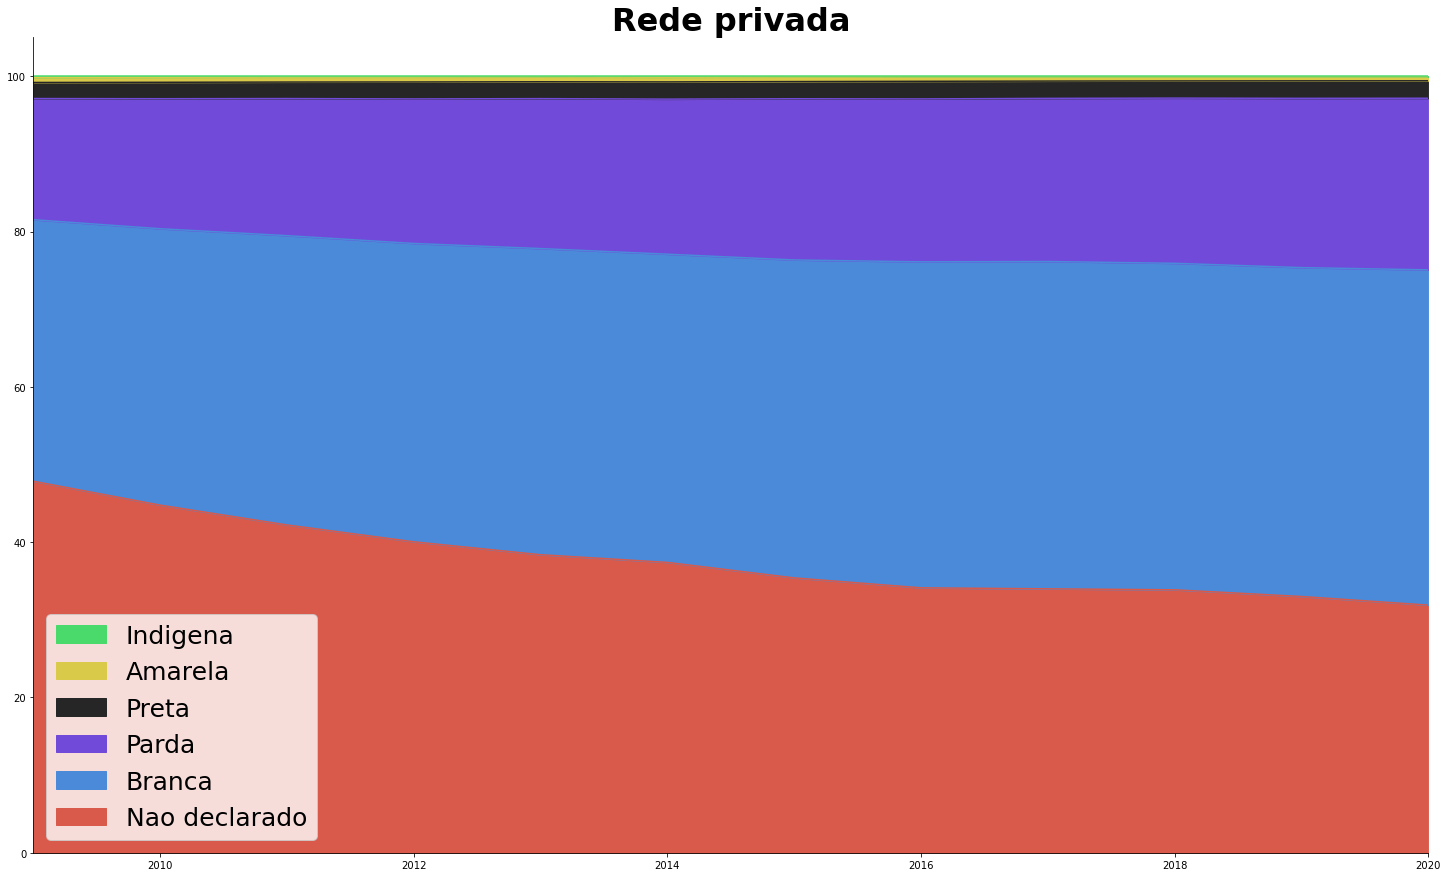

In [96]:
plot_rede(matriculas_rede, 'privada')

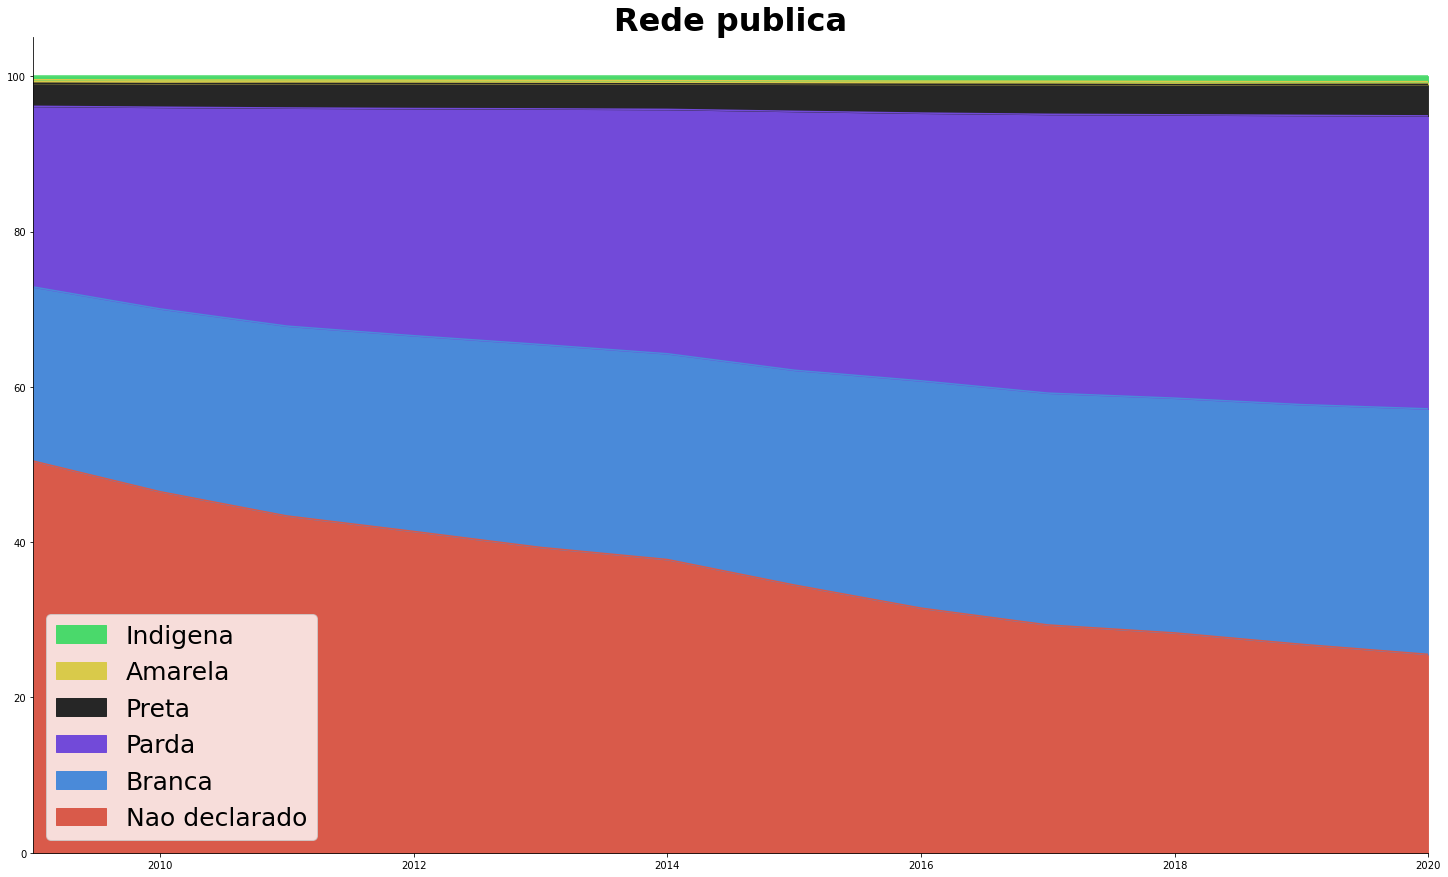

In [97]:
plot_rede(matriculas_rede, 'publica')

### Map Plot

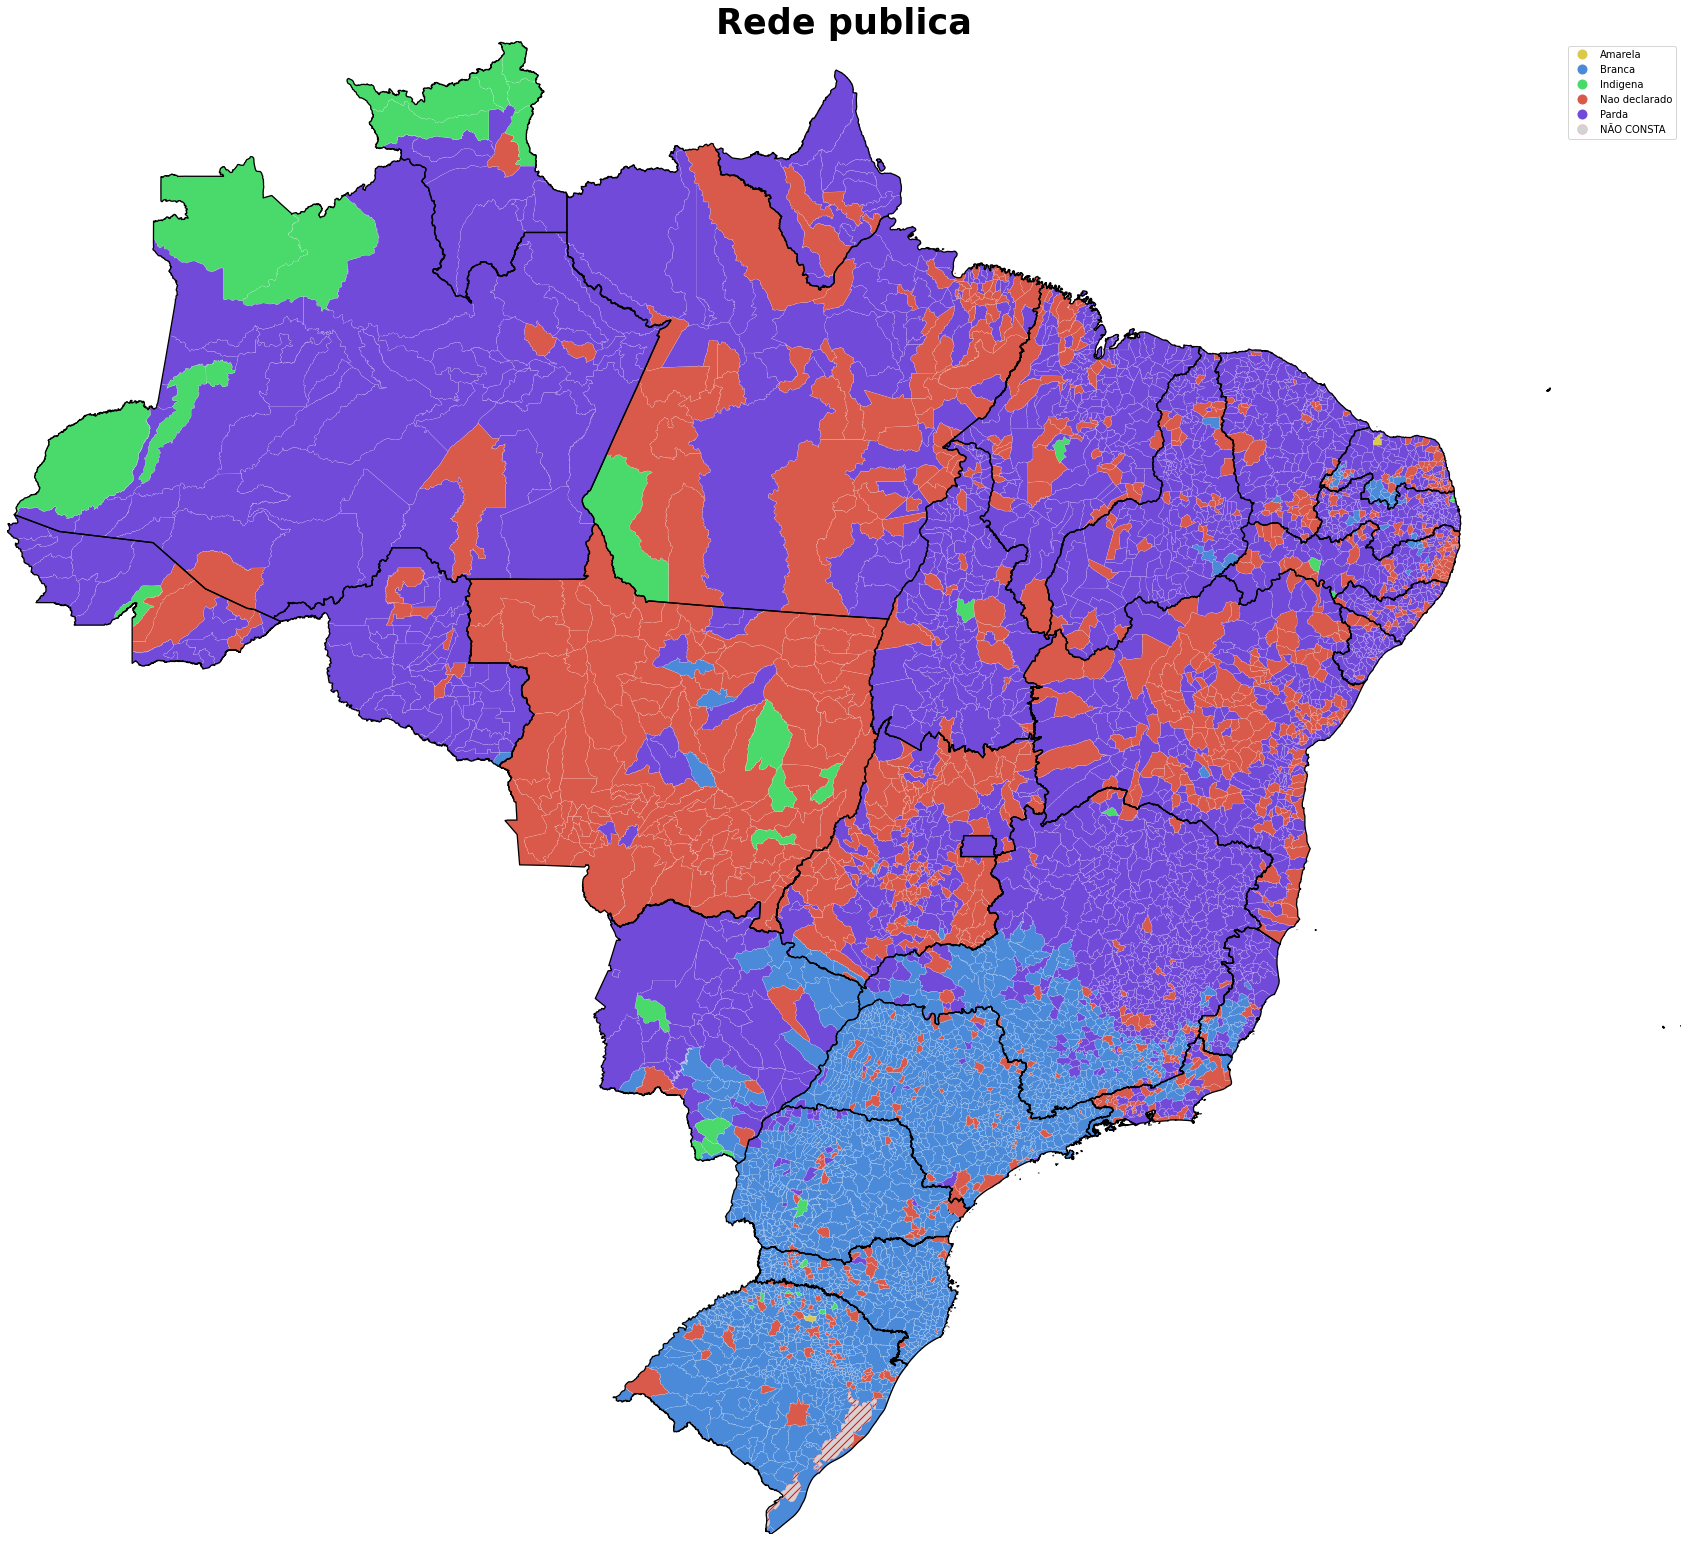

In [98]:


fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot()

colors = [
    palete['amarelo'],
    palete['azul'],
    palete['verde'],
    palete['vermelho'],
    palete['roxo'],
]

missing_kwds = {
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "NÃO CONSTA",
    }

# Create a colormap using only the colours in this group
cmap = ListedColormap(colors)

df_publico.plot(column='raca_cor',
        categorical=True,
        cmap=cmap,
        ax=ax1, 
        missing_kwds=missing_kwds,
        edgecolor='#FFFFFF',
        linewidth = 0.1,
        legend=True
       )
states.geometry.boundary.plot(color=None,edgecolor='#000000',linewidth = 1.3, ax=ax1)
ax1.set_title('Rede publica', fontsize=35,fontweight='bold')

ax1.axis('off')
ax1.margins(x=0, y=0)
# plt.savefig('../images/tipos_contratacoes_mapa.png', dpi=300, transparent=True, bbox_inches = 'tight', pad_inches = 0)

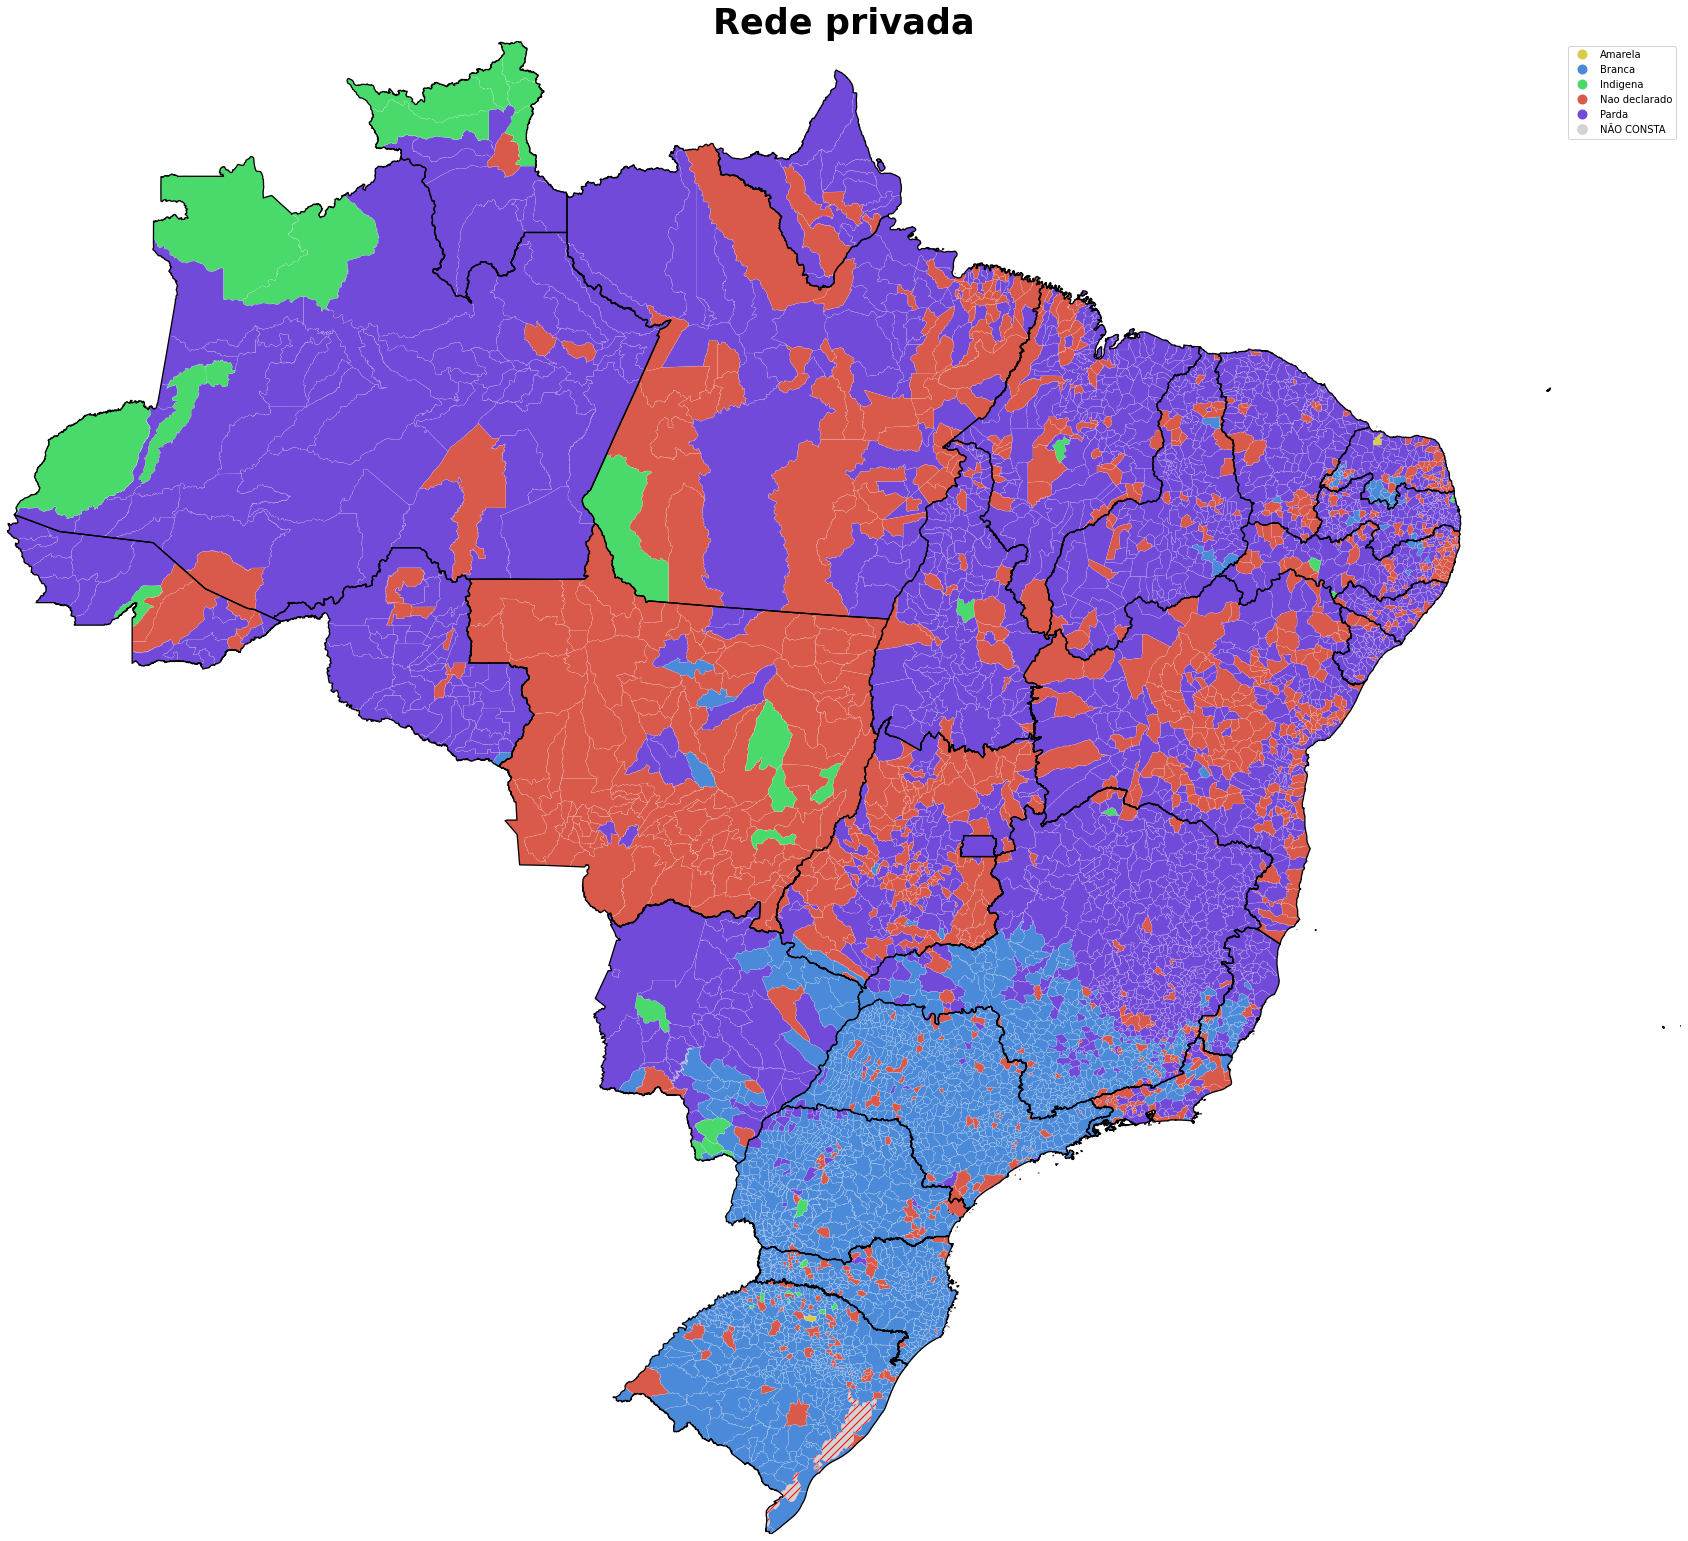

In [99]:
cols = ['id_municipio','name_muni','rede','raca_cor','matriculas','geometry']
df_publico[cols]

fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot()

colors = [
    palete['amarelo'],
    palete['azul'],
    palete['verde'],
    palete['vermelho'],
    palete['roxo'],

]

missing_kwds = {
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "NÃO CONSTA",
    }

# Create a colormap using only the colours in this group
cmap = ListedColormap(colors)

df_privado.plot(column='raca_cor',
        categorical=True,
        cmap=cmap,
        ax=ax1, 
        missing_kwds=missing_kwds,
        edgecolor='#FFFFFF',
        linewidth = 0.1,
        legend=True
       )
states.geometry.boundary.plot(color=None,edgecolor='#000000',linewidth = 1.3, ax=ax1)
ax1.set_title('Rede privada', fontsize=35,fontweight='bold')

ax1.axis('off')
ax1.margins(x=0, y=0)
# plt.savefig('../images/tipos_contratacoes_mapa.png', dpi=300, transparent=True, bbox_inches = 'tight', pad_inches = 0)

### Continuos

In [101]:
replace_raca_cor = {
    "Parda": "Preto",
    "Indigena": "Preto",
    "Preta": "Preto",
    "Branca": "Branco",
    "Amarela": "Branco",
}


mask_publico_c = (matriculas_municipio["rede"] == "publica") & (
    matriculas_municipio["raca_cor"] != "Nao declarado"
)

publico_c = matriculas_municipio[mask_publico_c]
publico_c["raca_cor"] = (
    publico_c["raca_cor"]
    .map(replace_raca_cor)

)
publico_c = (
    publico_c
    .sort_values(by=["id_municipio", "matriculas"], ascending=False)
    .drop_duplicates(subset="id_municipio", keep="first")
)    


mask_privado_c= (matriculas_municipio["rede"] == "privada") & (
    matriculas_municipio["raca_cor"] != "Nao declarado"
)

privado_c = matriculas_municipio[mask_privado_c]
privado_c["raca_cor"] = (
    privado_c["raca_cor"]
    .map(replace_raca_cor)

)
privado_c = (
    privado_c
    .sort_values(by=["id_municipio", "matriculas"], ascending=False)
    .drop_duplicates(subset="id_municipio", keep="first")
)    


In [102]:
mun = read_municipality(code_muni="all", year=2019)
states = read_state(code_state="all", year=2019)

df_publico_c = pd.merge(publico_c,mun, left_on='id_municipio', right_on='code_muni', how='outer')
df_publico_c = gpd.GeoDataFrame(df_publico_c)

cols = ['id_municipio','name_muni','rede','raca_cor','matriculas','geometry']
df_publico_c = df_publico_c[cols]

df_privado_c = pd.merge(privado_c,mun, left_on='id_municipio', right_on='code_muni', how='outer')
df_privado_c = gpd.GeoDataFrame(df_privado_c)

cols = ['id_municipio','name_muni','rede','raca_cor','matriculas','geometry']
df_privado_c = df_privado_c[cols]


In [103]:
['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061']

['#67001f',
 '#b2182b',
 '#d6604d',
 '#f4a582',
 '#fddbc7',
 '#d1e5f0',
 '#92c5de',
 '#4393c3',
 '#2166ac',
 '#053061']

In [113]:
def plot_continuos_map(df_publico, rede_selected):
    var='matriculas'

    fig = plt.figure(figsize=(30,30))
    ax = plt.subplot(1,1,1)
    bins = [50,60,70,80,90]
    
    colors_preto = ['#fcbba1','#fc9272','#fb6a4a','#ef3b2c','#cb181d','#99000d']

    cmap = ListedColormap(colors_preto)

    missing_kwds = {
            "color": "lightgrey",
            "edgecolor": "red",
            "hatch": "///",
            "label": "NÃO CONSTA",
        }

    df_publico[df_publico['raca_cor']=='Preto'].plot(column=var,
                ax=ax,
    #             legend=True,
    #             legend_kwds = legend_kwds,
                cmap=cmap,
                missing_kwds=missing_kwds,
                scheme='user_defined', 
                classification_kwds={'bins':bins},
                edgecolor='#FFFFFF',
                linewidth = 0.1
           )



    colors_branco = ['#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#084594']

    cmap = ListedColormap(colors_branco)
    df_publico[df_publico['raca_cor']=='Branco'].plot(column=var,
                ax=ax,
    #             legend=True,
    #             legend_kwds = legend_kwds,
                cmap=cmap,
                missing_kwds=missing_kwds,
                scheme='user_defined', 
                classification_kwds={'bins':bins},
                edgecolor='#FFFFFF',
                linewidth = 0.1
    )
    states.geometry.boundary.plot(color=None,edgecolor='#000000',linewidth = 1.3, ax=ax)


    cmap = ListedColormap(colors_preto[::-1] + colors_branco)

    colorscale = cmap
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_vertical(size="1%", pad=0.5, axes_class=plt.Axes)
    vmax = df_publico[var].values.max()
    vmin = df_publico[var].values.min()
    norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax)
    mappable = plt.cm.ScalarMappable(cmap=colorscale, norm=norm)
    fig.add_axes(ax_cb)
    # labels = [-0.085,-0.050, -0.015,0.015,0.05,0.085]
    cbar = fig.colorbar(mappable, cax=ax_cb,orientation='horizontal')
    cbar.ax.set_xticklabels([])
    cbar.ax.tick_params(labelsize=28) 

    ax.set_title(f'Rede {rede_selected}', fontsize=35,fontweight='bold', pad=100)


    ax.axis('off')

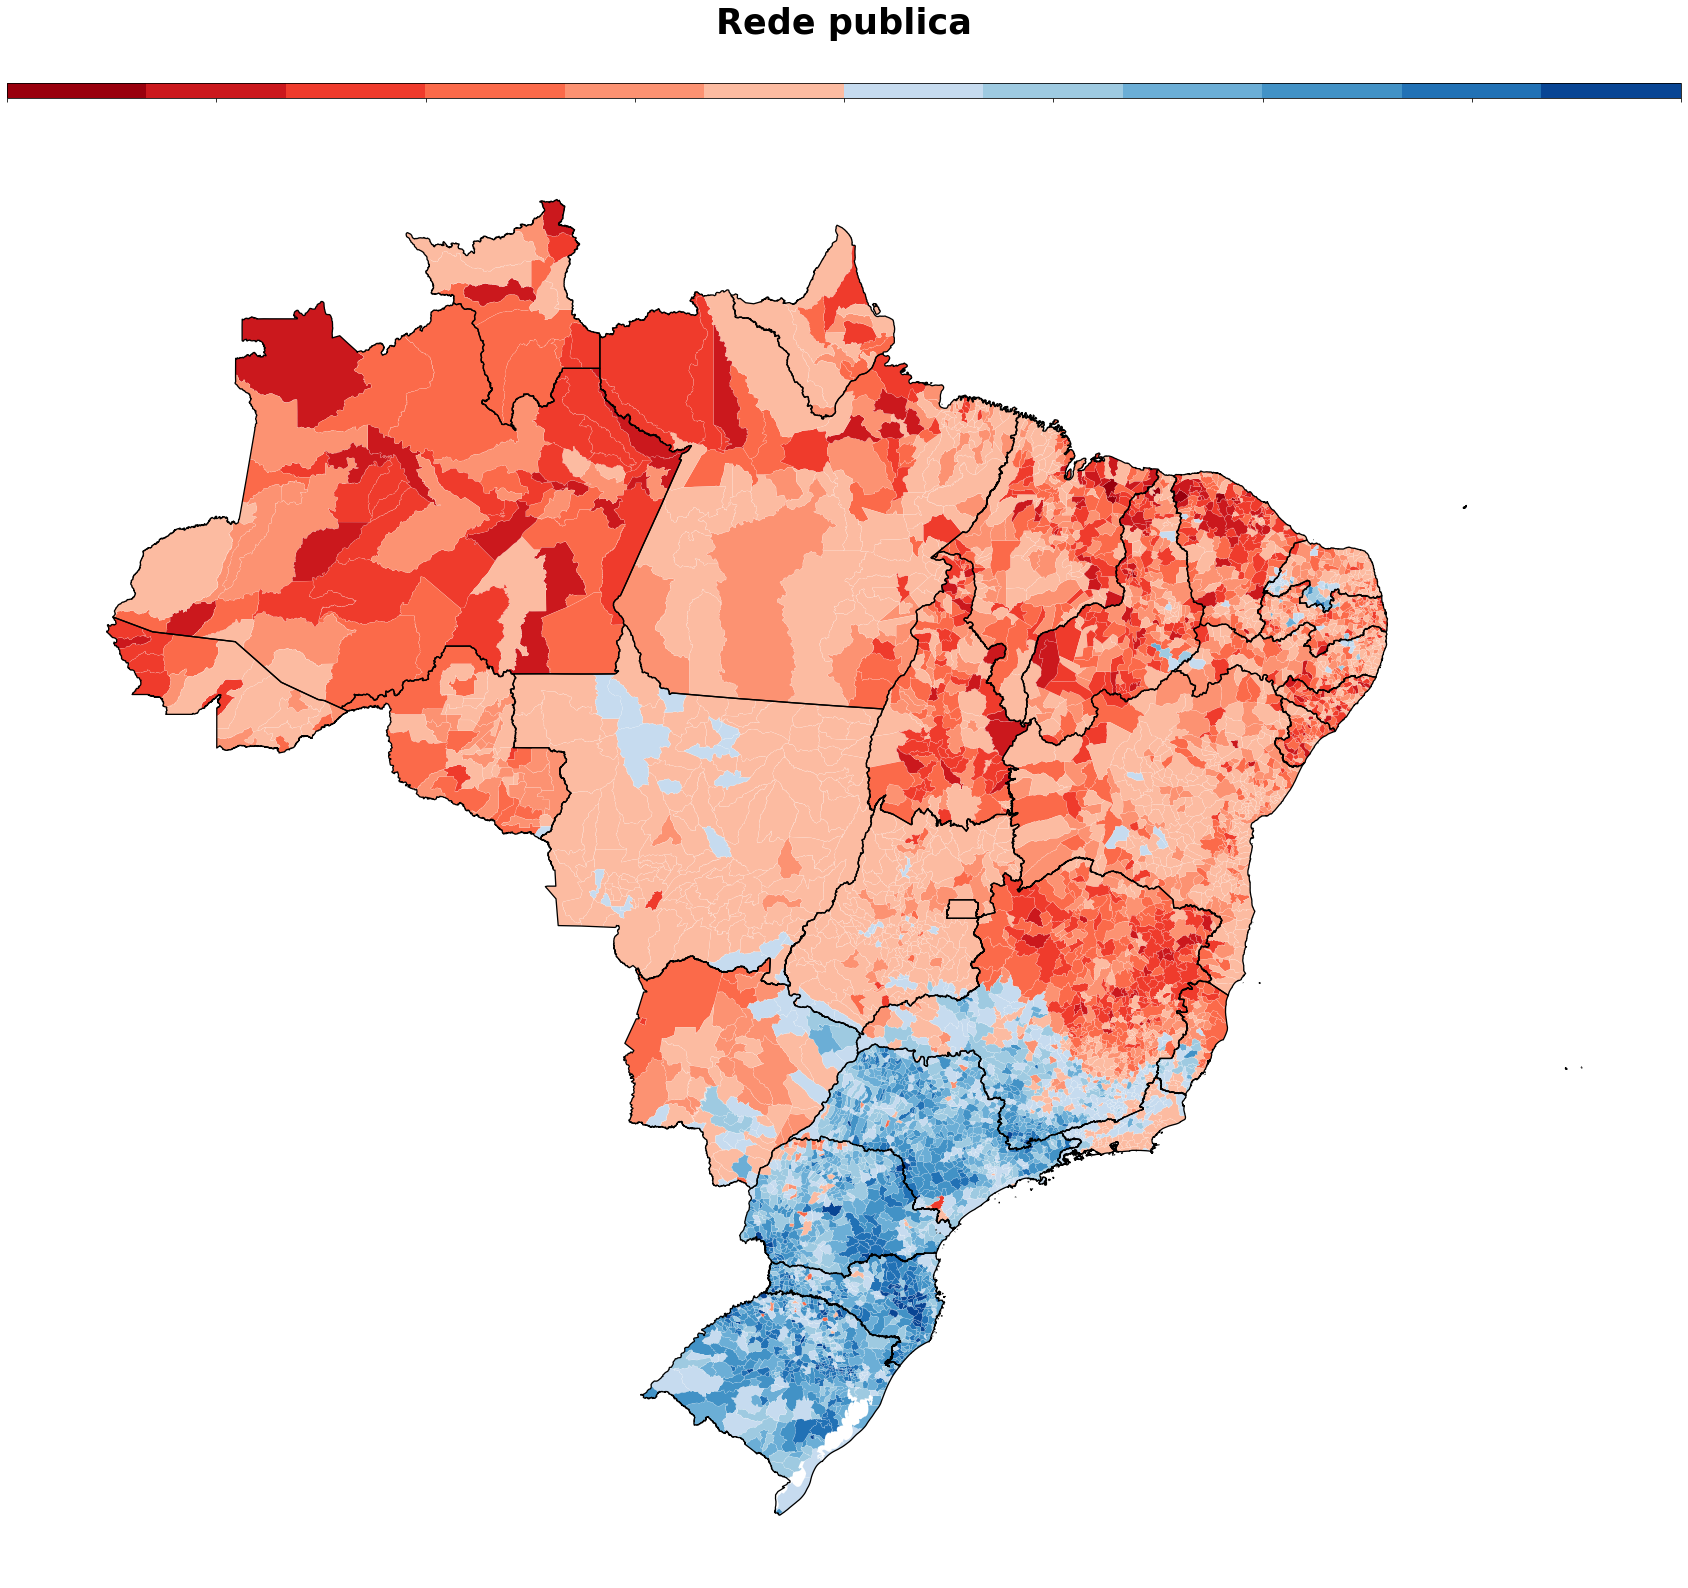

In [114]:
plot_continuos_map(df_publico_c, 'publica')

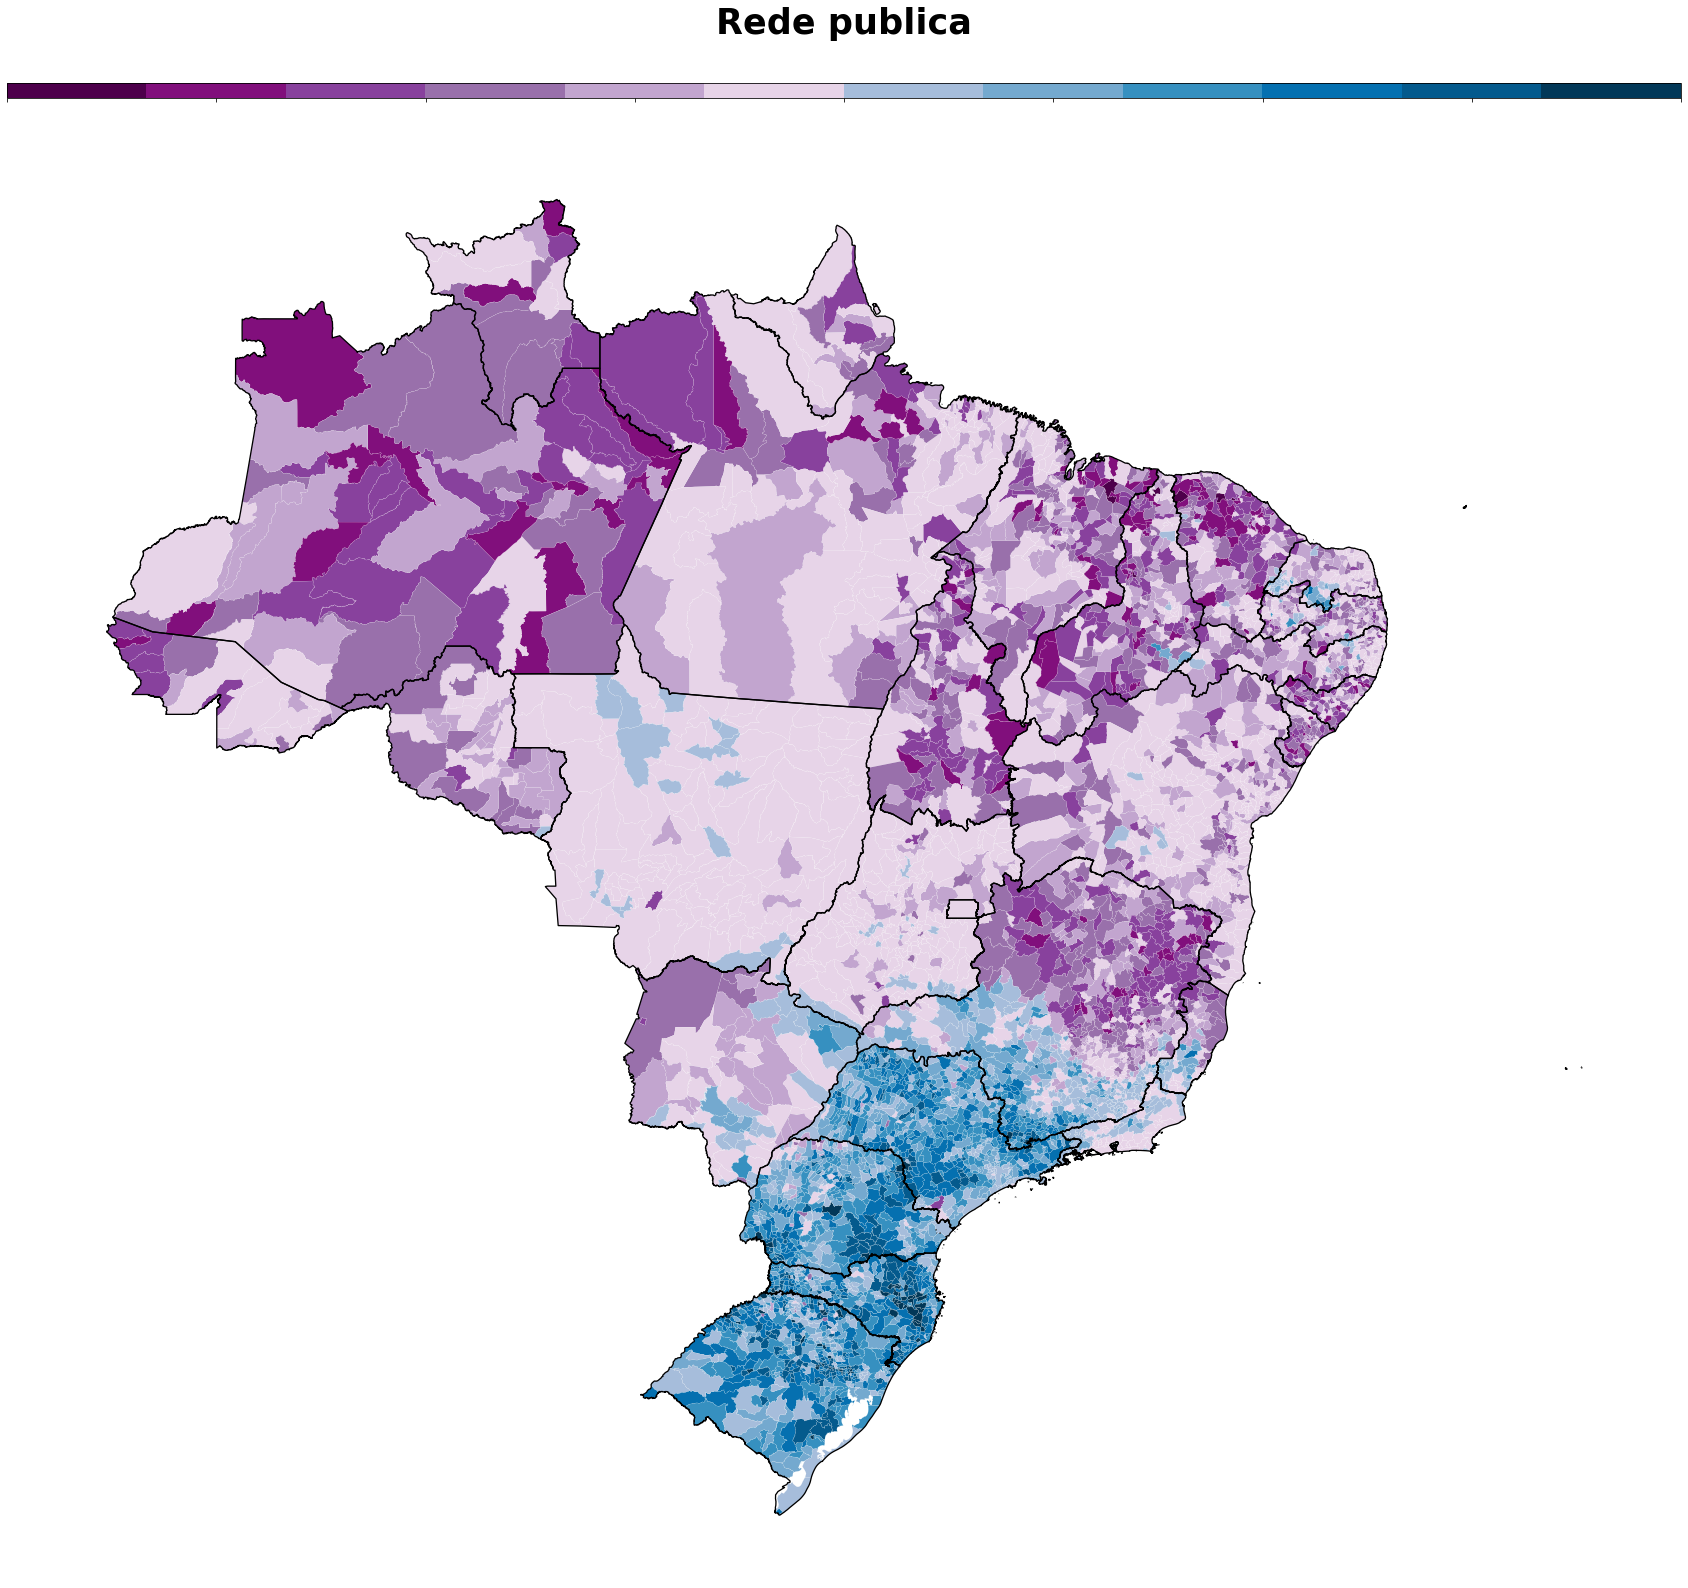

In [59]:
plot_continuos_map(df_publico, 'publica')

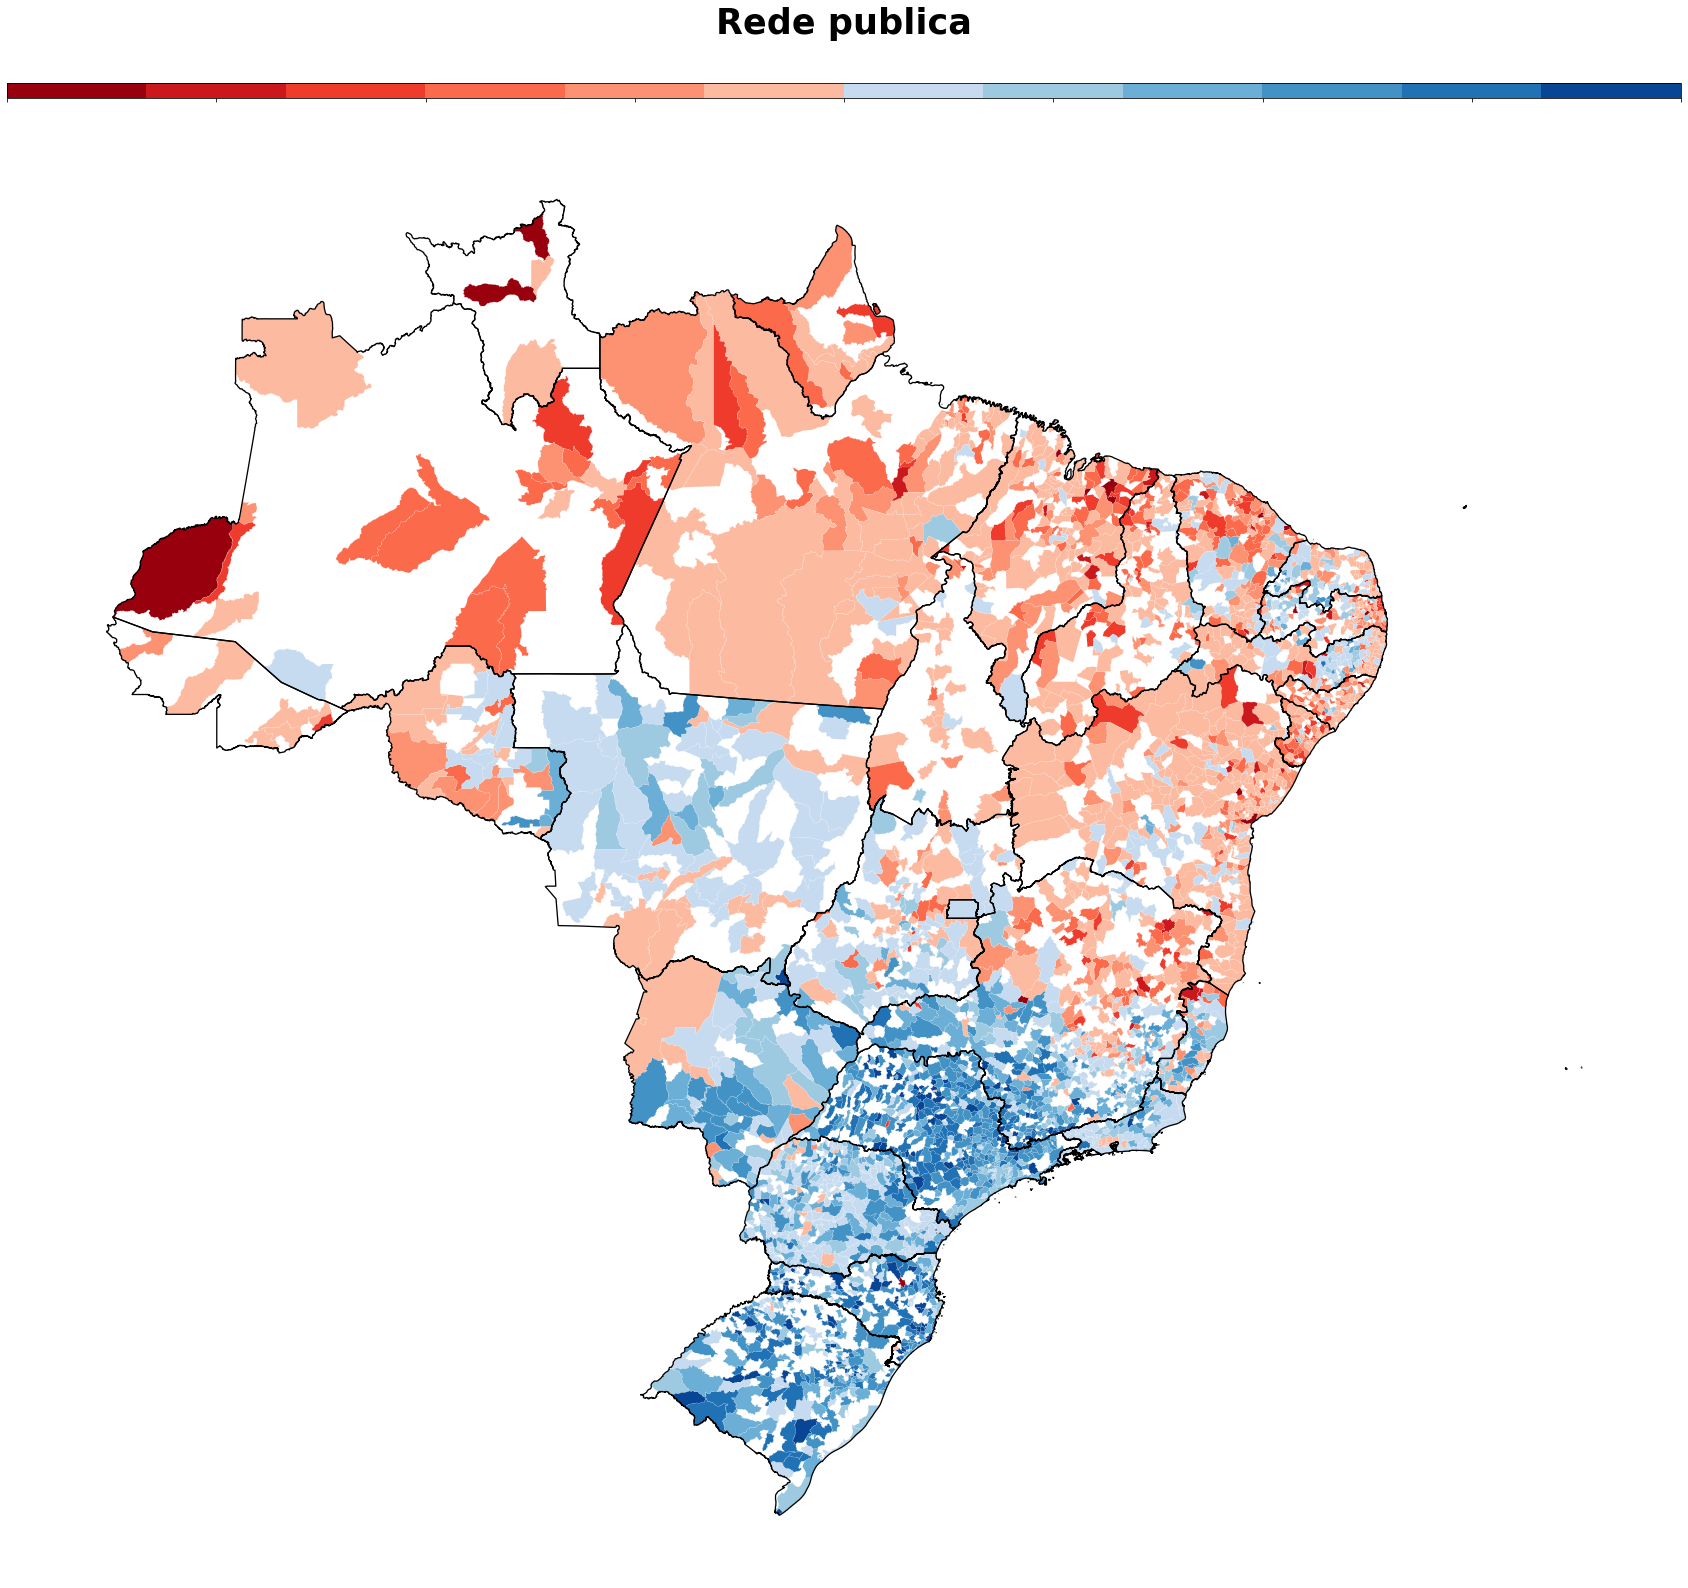

In [115]:
plot_continuos_map(df_privado_c, 'publica')

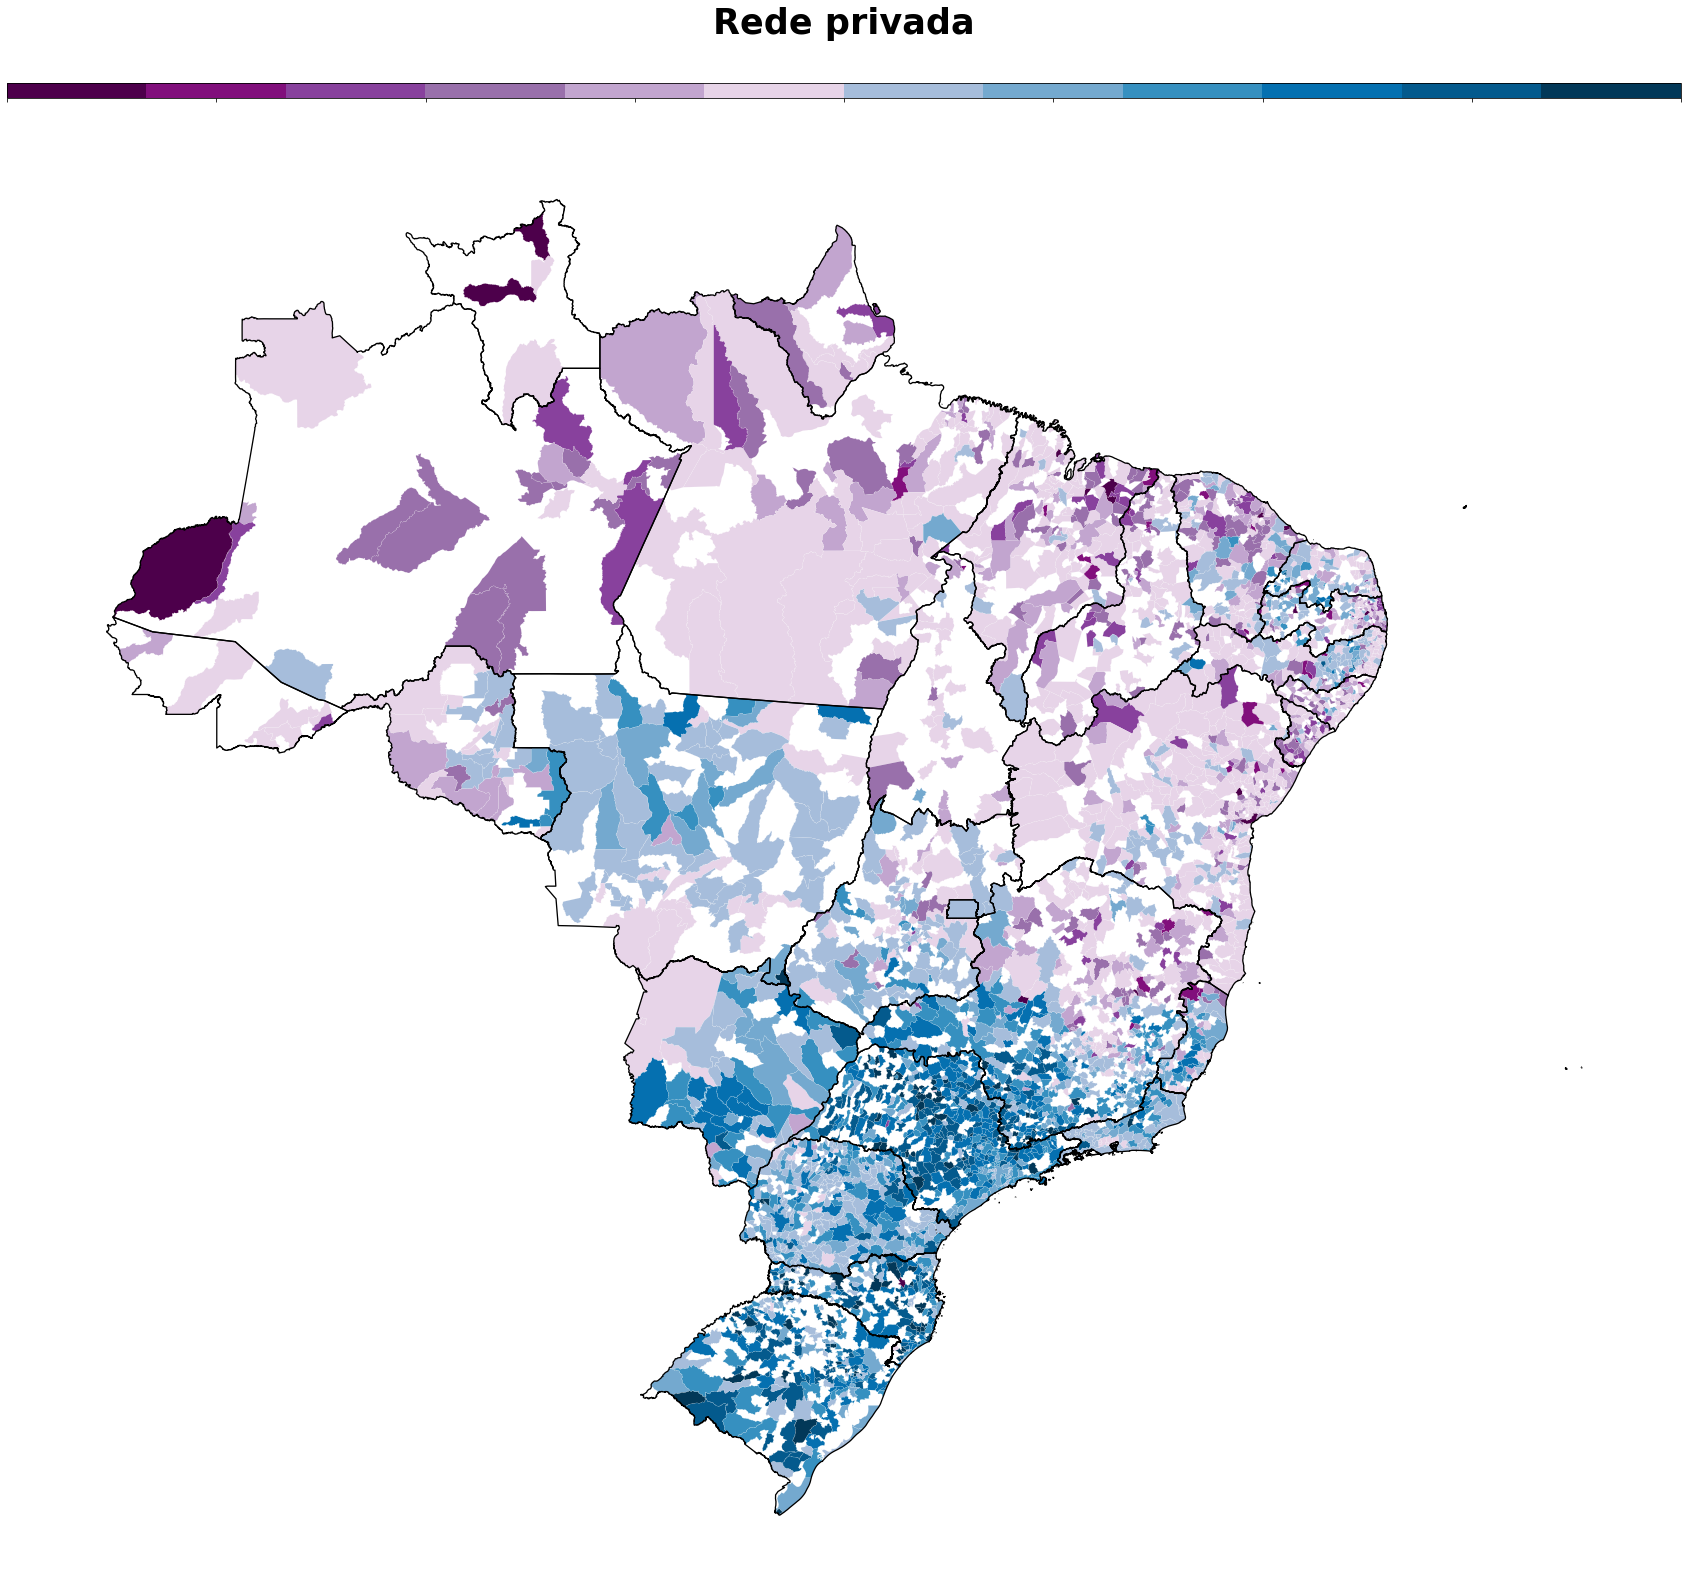

In [362]:
plot_continuos_map(df_privado, 'privada')